<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/Features_ORAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/ORAN/Network_Dataset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [7]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53870/53870 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step
               Feature  Mutual_Info  RF_Importance  AE_Recon_Error  Rank_MI  \
5                proto     0.128865            0.0        1.280476      5.0   
23  is_file_transfered     0.188450            0.0        1.140297      1.0   
17            ip_proto     0.128397            0.0        1.138923      6.0   
1               src_ip     0.051690            0.0        1.108188     11.0   
3               dst_ip     0.013070            0.0        1.166077     16.0   
20   files_total_bytes     0.005164            0.0        1.241888     17.0   
19     attack_category     0.052336            0.0        1.058600     10.0   
21         is_GET_mthd     0.185218            0.0        0.933970      2.0   
22   http_status_error     0.129841            0.0        0.984639      4.0   
24        traffic_type     0.126867            0.0        1.005533      7.0   
12             history     0.061617            0.0        1.021105      9.0   
14    

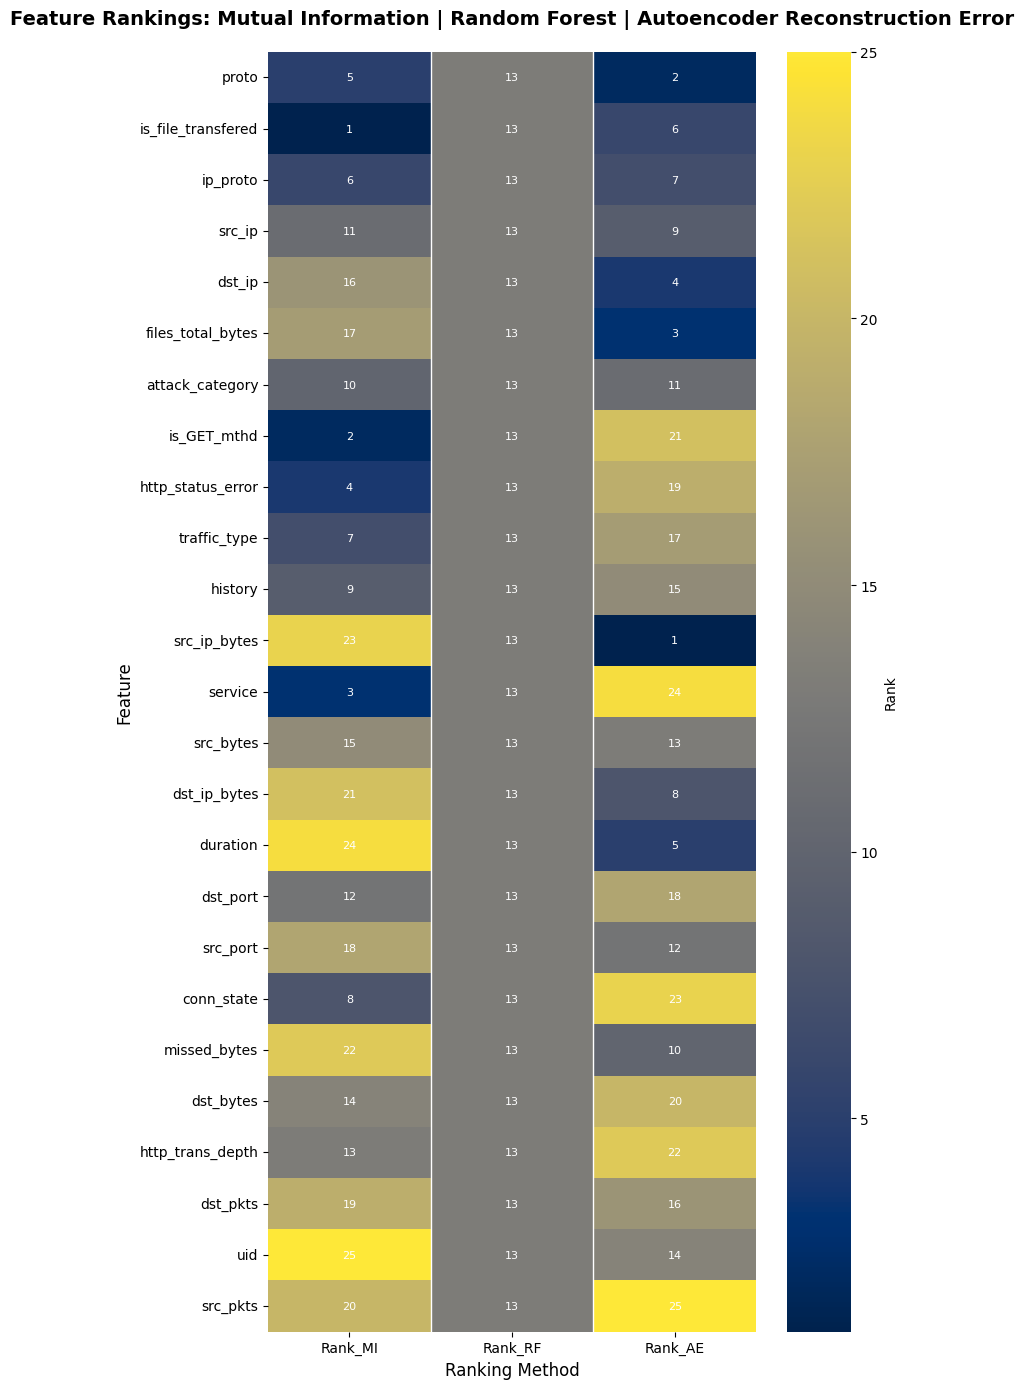

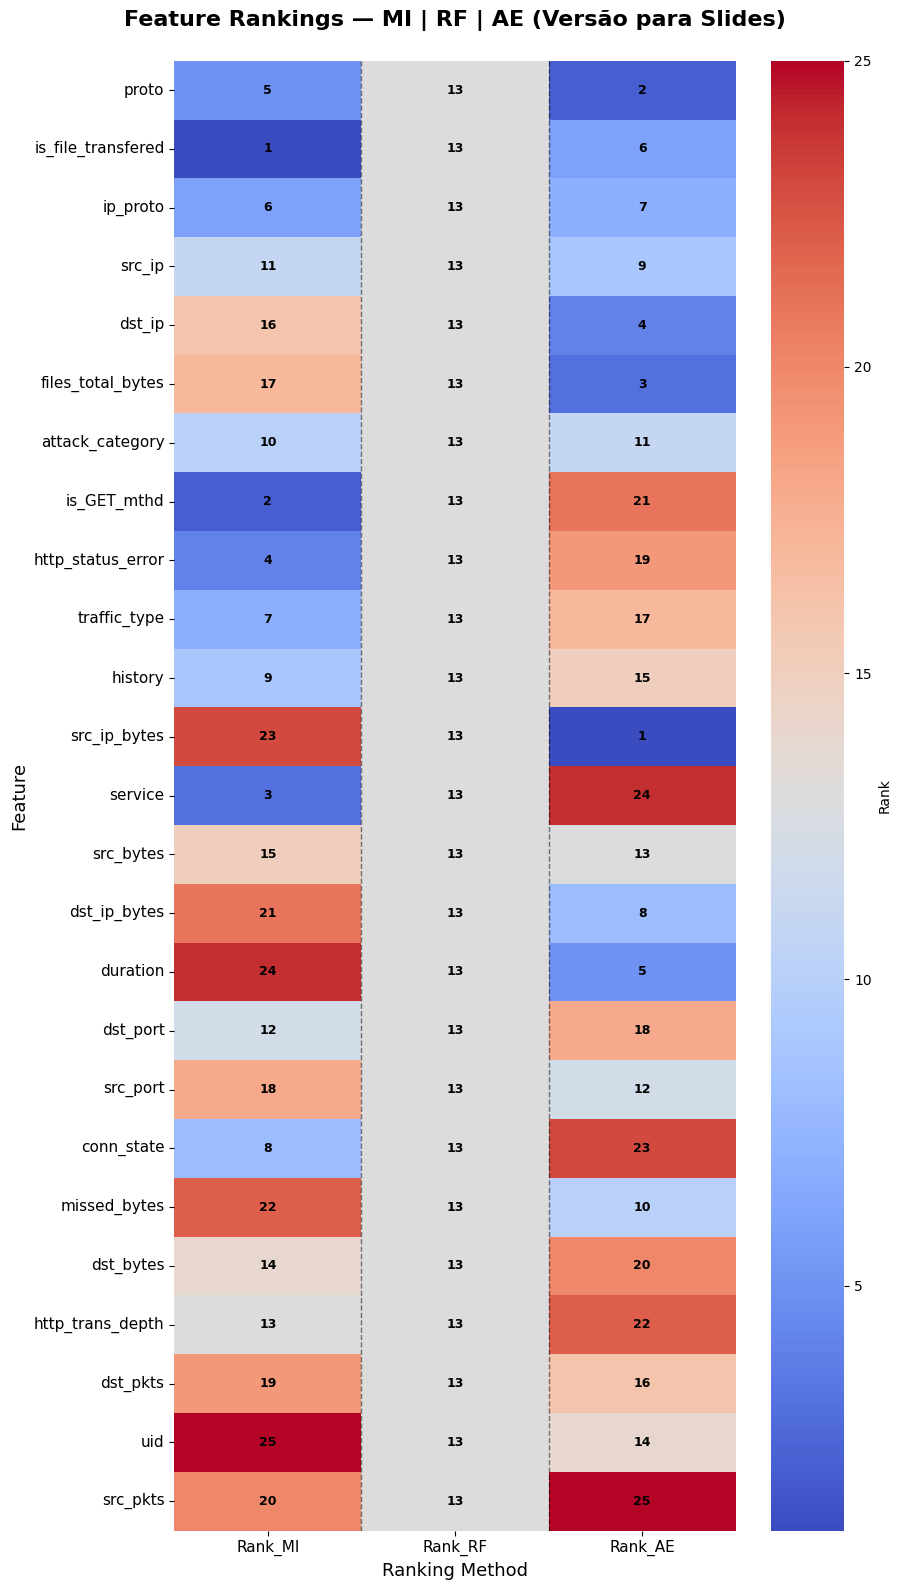

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# =====================
# 1. Preparar dataset
# =====================
df = encoded  # seu DataFrame
df_features = df.drop(columns=['attack_type']).copy()
features = df_features.columns.tolist()

# Converter colunas categóricas para numéricas
for col in df_features.columns:
    if df_features[col].dtype == 'object':
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

X = df_features.values
y = df['attack_type'].values
y_bin = (y != 'Benign').astype(int)  # 0=Benigno, 1=Ataque

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================
# 2. Mutual Information
# =====================
mi = mutual_info_classif(X_scaled, y_bin, discrete_features=False)
mi_df = pd.DataFrame({'Feature': features, 'Mutual_Info': mi})

# =====================
# 3. Random Forest Importance
# =====================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_bin)
rf_importances = rf.feature_importances_
rf_df = pd.DataFrame({'Feature': features, 'RF_Importance': rf_importances})

# =====================
# 4. Autoencoder Reconstruction Error
# =====================
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(encoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    ae = models.Model(inputs=input_layer, outputs=output_layer)
    ae.compile(optimizer='adam', loss='mse')
    return ae

ae = build_autoencoder(X_scaled.shape[1])
ae.fit(X_scaled[y_bin == 0], X_scaled[y_bin == 0],
       epochs=20, batch_size=128, shuffle=True, verbose=0)

X_pred = ae.predict(X_scaled)
recon_error = np.mean((X_scaled - X_pred) ** 2, axis=0)
ae_df = pd.DataFrame({'Feature': features, 'AE_Recon_Error': recon_error})

# =====================
# 5. Consolidar tabelas
# =====================
consolidated = mi_df.merge(rf_df, on='Feature').merge(ae_df, on='Feature')

# Calcular rank individual e médio
consolidated['Rank_MI'] = consolidated['Mutual_Info'].rank(ascending=False)
consolidated['Rank_RF'] = consolidated['RF_Importance'].rank(ascending=False)
consolidated['Rank_AE'] = consolidated['AE_Recon_Error'].rank(ascending=False)
consolidated['Mean_Rank'] = consolidated[['Rank_MI','Rank_RF','Rank_AE']].mean(axis=1)

# Ordenar pelo Rank médio
consolidated = consolidated.sort_values(by='Mean_Rank', ascending=True)

# =====================
# 6. Mostrar e salvar
# =====================
pd.set_option('display.max_columns', None)
print(consolidated)
consolidated.to_csv("feature_correlation_ranking.csv", index=False)

# =====================
# 7. Heatmaps aprimorados
# =====================
df_rank = consolidated[['Feature', 'Rank_MI', 'Rank_RF', 'Rank_AE']].set_index('Feature')

# -------- Versão 1: Para Artigo --------
plt.figure(figsize=(8, 14))
sns.heatmap(
    df_rank,
    annot=True, fmt=".0f", cmap="cividis",
    cbar_kws={'label': 'Rank'},
    annot_kws={"size":8, "color":"white"}
)
plt.title("Feature Rankings: Mutual Information | Random Forest | Autoencoder Reconstruction Error",
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Ranking Method", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)

# Linhas verticais para separar blocos
for x in range(1, df_rank.shape[1]):
    plt.axvline(x, color='white', lw=1)

plt.tight_layout()
plt.savefig("feature_ranking_article.png", dpi=300, bbox_inches='tight')
plt.show()

# -------- Versão 2: Para Apresentação --------
plt.figure(figsize=(9, 16))
sns.heatmap(
    df_rank,
    annot=True, fmt=".0f", cmap="coolwarm",
    cbar_kws={'label': 'Rank'},
    annot_kws={"size":9, "color":"black", "weight":"bold"}
)
plt.title("Feature Rankings — MI | RF | AE (Versão para Slides)",
          fontsize=16, fontweight='bold', pad=25)
plt.xlabel("Ranking Method", fontsize=13)
plt.ylabel("Feature", fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=11)

for x in range(1, df_rank.shape[1]):
    plt.axvline(x, color='black', lw=1, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("feature_ranking_presentation.png", dpi=300, bbox_inches='tight')
plt.show()